# New York Working Families Tax Credit Act

https://www.nysenate.gov/legislation/bills/2021/S9610

* Limits NY EITC to childless filers
* Replaces NY CTC with a new one that’s \\$1,500 per child, phasing down to \\$500 at a 2% rate above \\$25k (non-joint) or \\$50k (joint)
* Pays quarterly


In [1]:
from policyengine_us import Microsimulation, Simulation
from policyengine_core.reforms import Reform
from policyengine_us.model_api import *

# Define the reform.
MAX_AMOUNT = 1_500
MIN_AMOUNT = 500
MTR = 0.02
THRESHOLD_JOINT = 50_000
THRESHOLD_NON_JOINT = 25_000

# Limit NY EITC to childless filers.
class ny_eitc(Variable):
    value_type = float
    entity = TaxUnit
    label = "NY EITC"
    unit = USD
    definition_period = YEAR
    reference = (
        "https://www.nysenate.gov/legislation/laws/TAX/606",  # (d)
        "https://legislation.nysenate.gov/pdf/bills/2021/S9610"  # § 3
    )
    defined_for = StateCode.NY

    def formula(tax_unit, period, parameters):
        eitc = tax_unit("earned_income_tax_credit", period)
        rate = parameters(period).gov.states.ny.tax.income.credits.eitc.match
        tentative_nys_eitc = eitc * rate
        household_credit = tax_unit("ny_household_credit", period)
        eligible = tax_unit("eitc_child_count", period) == 0
        return eligible * max_(0, tentative_nys_eitc - household_credit)


class ny_ctc(Variable):
    value_type = float
    entity = TaxUnit
    label = "NY CTC"
    documentation = "New York's Empire State Child Credit"
    unit = USD
    definition_period = YEAR
    reference = (
        "https://www.nysenate.gov/legislation/laws/TAX/606",  # (c-1)
        "https://legislation.nysenate.gov/pdf/bills/2021/S9610"  # § 3
    )
    defined_for = StateCode.NY

    def formula(tax_unit, period, parameters):
        ny_agi = tax_unit("ny_agi", period)
        eligible_children = tax_unit("eitc_child_count", period)
        max_amount = MAX_AMOUNT * eligible_children
        min_amount = MIN_AMOUNT * eligible_children
        filing_status = tax_unit("filing_status", period)
        threshold = where(
            filing_status == filing_status.possible_values.JOINT,
            THRESHOLD_JOINT,
            THRESHOLD_NON_JOINT,
        )
        excess = max_(0, ny_agi - threshold)
        reduction = excess * MTR
        return max_(max_amount - reduction, min_amount)


class implement_ny_wftc(Reform):
    def apply(self):
        self.update_variable(ny_eitc)
        self.update_variable(ny_ctc)


baseline = Microsimulation()
reformed = Microsimulation(reform=implement_ny_wftc)

(
    reformed.calc("ny_income_tax").sum() / 1e9
    - baseline.calc("ny_income_tax").sum() / 1e9
)


-3.10809176350293

In [9]:
import pandas as pd

YEAR = 2023


def make_hh(adults, children, child_age):
    people = dict(head=dict(age=30))
    members = ["head"]
    if adults == 2:
        people["spouse"] = dict(age=30)
        members += ["spouse"]
    for i in range(children):
        people[f"child{i}"] = dict(age=child_age)
        members += [f"child{i}"]
    return dict(
        people=people,
        households=dict(household=dict(members=members, state_code="NY")),
        # Same impact for households with $250k+ income, so show up to $300k.
        # $1k increments.
        axes=[[dict(name="employment_income", count=301, min=0, max=300_000)]],
    )


l = []
for adults in [1, 2]:
    for children in [0, 1, 2, 3, 4]:
        for child_age in [1, 5]:
            hh = make_hh(adults, children, child_age)
            baseline_hh = Simulation(situation=hh)
            reformed_hh = Simulation(situation=hh, reform=implement_ny_wftc)
            l.append(
                pd.DataFrame(
                    dict(
                        adults=adults,
                        children=children,
                        child_age=child_age,
                        # Reshape combined array to get head's varied earnings.
                        earnings=baseline_hh.calculate(
                            "employment_income", YEAR
                        )[0 :: (adults + children)],
                        baseline_net_income=baseline_hh.calculate(
                            "spm_unit_net_income", YEAR
                        ),
                        reformed_net_income=reformed_hh.calculate(
                            "spm_unit_net_income", YEAR
                        ),
                        baseline_ny_ctc=baseline_hh.calculate("ny_ctc", YEAR),
                        reformed_ny_ctc=reformed_hh.calculate("ny_ctc", YEAR),
                        baseline_ny_eitc=baseline_hh.calculate(
                            "ny_eitc", YEAR
                        ),
                        reformed_ny_eitc=reformed_hh.calculate(
                            "ny_eitc", YEAR
                        ),
                    )
                )
            )

df = pd.concat(l)
df["net_gain"] = df["reformed_net_income"] - df["baseline_net_income"]


In [48]:
df["marital_status"] = np.where(df.adults == 1, "Single", "Married")
df["child_ages"] = np.where(df.child_age < 4, "All children under age 4", "All children age 4 or above")
df["children_str"] = df.children.astype(str)

def make_label(row, verb, column):
    return "{0} parents of {1} child{2} {3} with ${4:,} earnings would {5} <b>${6:,}</b>".format(
        row['marital_status'],
        row['children'],
        'ren' if row['children'] > 1 else '',
        "under age four" if row['child_age'] < 4 else "age four or above",
        round(row['earnings']),
        verb,
        round(row[column])
    )

df['label'] = df.apply(lambda row: make_label(row, "gain", "net_gain"), axis=1)
df['label_new_ctc'] = df.apply(lambda row: make_label(row, "receive", "reformed_ny_ctc"), axis=1)

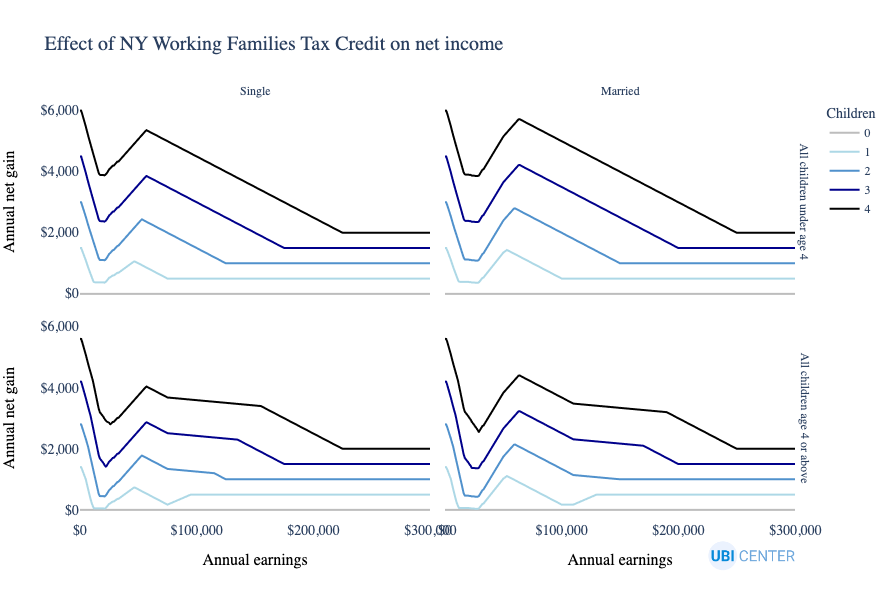

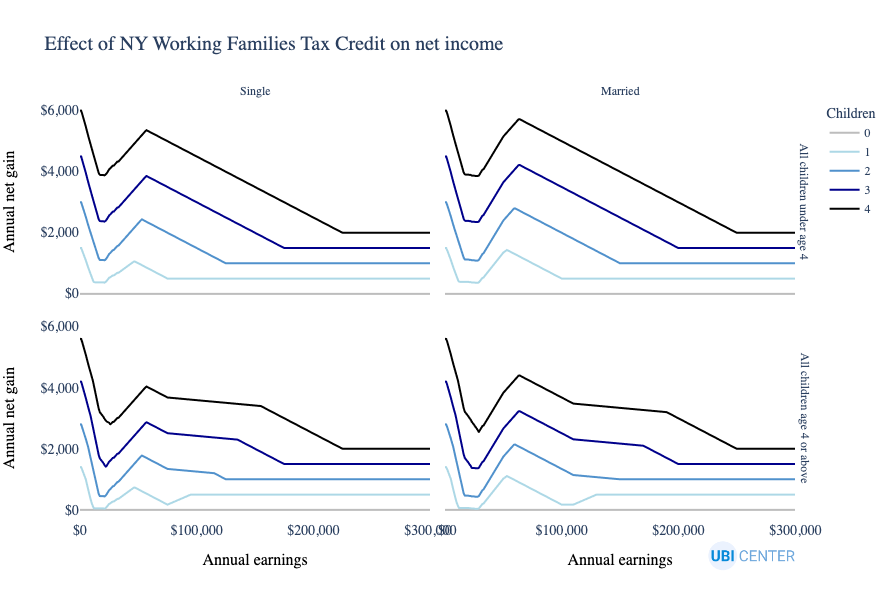

In [52]:
import plotly.express as px
from ubicenter import format_fig

LIGHT_GRAY = "#F5F5F5"
GRAY = "#BDBDBD"
BLUE = "#5091cc"
LIGHT_BLUE = "lightblue"
DARK_BLUE = "darkblue"
BLACK = "black"

COLOR_MAP = {"0": GRAY, "1": LIGHT_BLUE, "2": BLUE, "3": DARK_BLUE, "4": BLACK}


LABELS = dict(
    earnings="Annual earnings",
    marital_status="Marital status",
    children_str="Children",
    child_ages="Age of children",
    net_gain="Annual net gain",
    reformed_ny_ctc="Reformed NY CTC",
)

def make_chart(y, label, title):
    fig = px.line(
        df,
        "earnings",
        y,
        color="children_str",
        facet_col="marital_status",
        facet_row="child_ages",
        title=title,
        labels=LABELS,
        color_discrete_map=COLOR_MAP,
        custom_data=[label]
    )
    fig.update_traces(hovertemplate="%{customdata[0]}<extra></extra>")
    fig.update_xaxes(tickformat="$,")
    fig.update_yaxes(tickformat="$,")

    # Remove `{variable}=` from facet labels.
    fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))

    format_fig(fig)
    
make_chart("net_gain", "label", "Effect of NY Working Families Tax Credit on net income")

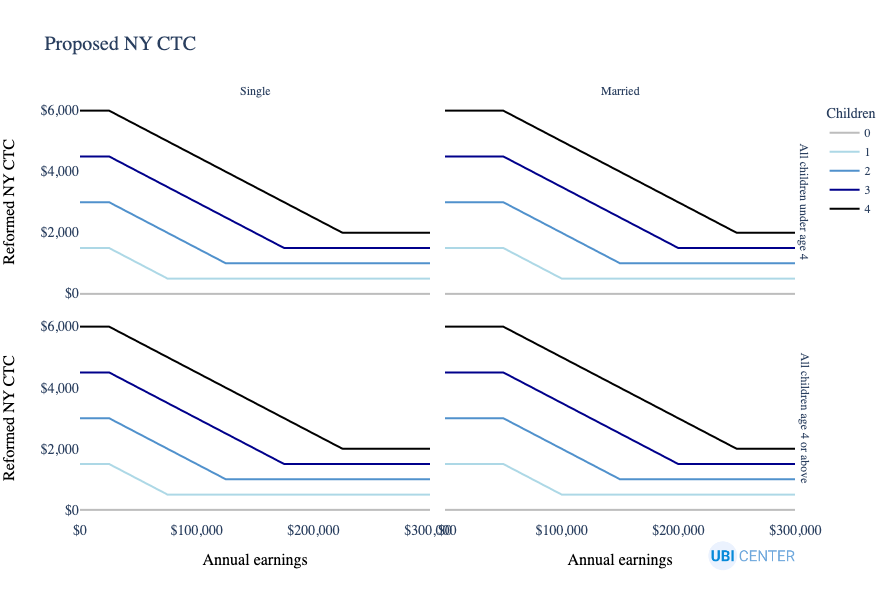

In [50]:
make_chart("reformed_ny_ctc", "label_new_ctc", "Proposed NY CTC")

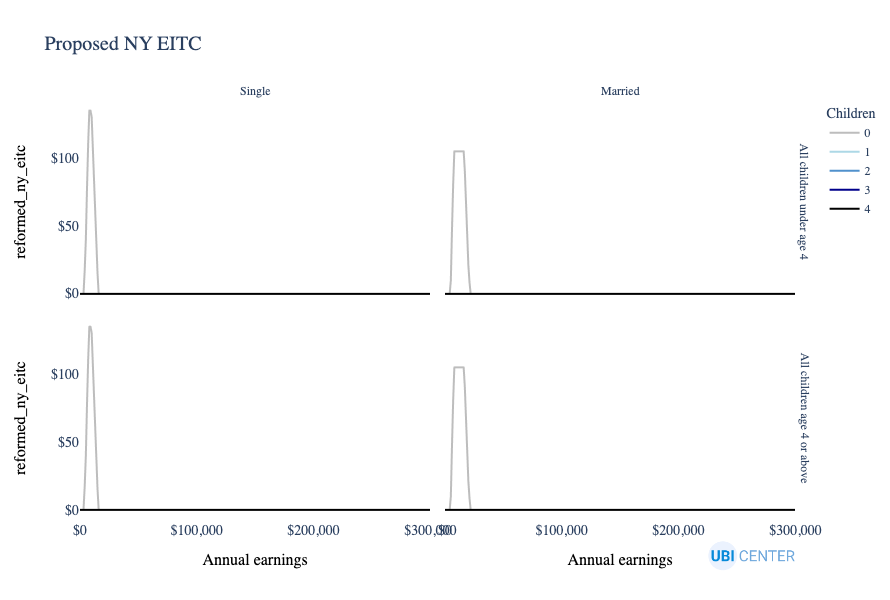

In [51]:
# No need for a fresh label - this is just to check we modeled EITC correctly.
make_chart("reformed_ny_eitc", "label", "Proposed NY EITC")
